In [1]:
import os
import argparse
import re
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
from transformers import AutoTokenizer, XLMRobertaModel, AutoConfig
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_argparser(config_path):
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, help='Directory path of twitter dataset')
#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    args = parser.parse_args(args=['--config', config_path])
    return args


def load_yml_config(cfg_path):
    with open(cfg_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [4]:
def data_preprocessing(df):
    for idx, row in df.iterrows():
        text = df.at[idx, 'text']

        # Replace '&amp;' with '&'
        text = re.sub(r'&amp;', '&', text)
        # Remove URL
        text = re.sub(r'https?://\S+|www\.\S+', '',text)
        # Remove numbers
        text = ''.join([i for i in text if not i.isdigit()])    
        # Remove html
        text = re.sub(r'<.*?>', '', text)
        # Remove &gt; <, &lt; >
        text = re.sub(r'&gt;', '',text)
        text = re.sub(r'&lt;', '',text)

        df.at[idx, 'text'] = text

        # require by the task
        if df.at[idx, 'label'] == 3:
            df.at[idx, 'label'] = 2
    return df

In [5]:
@dataclass(frozen=True)
class Dataset:
    data_dir: str
    trim_padding: bool
    labels: list


@dataclass(frozen=True)
class Model:
    name: str
    dropout: float
    max_len: int
    save_dir: str
    save_best: str
    save_last: str


@dataclass(frozen=True)
class Train:
    seed: int
    batch_size: int
    epochs: int
    lr: float
    eps: float


class TrainConfig:
    def __init__(self, **kwargs):
        self.dataset = Dataset(**kwargs['dataset'])
        self.model = Model(**kwargs['model'])
        self.train = Train(**kwargs['train'])

In [6]:
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tweets = dataframe['text'].values
        self.label = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    @property
    def n_labels(self):
        return len(set(self.label))

    def __getitem__(self, index):
        tweet = self.tweets[index]
        input = self.tokenizer.__call__(tweet, None, add_special_tokens=True, padding='max_length', 
                                        max_length=self.max_len, truncation=True)
        # convert token ids to tensors
        return {
            'input_ids': torch.tensor(input['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(input['attention_mask'], dtype=torch.long),
            'target': torch.tensor(self.label[index], dtype=torch.long)
        }

In [7]:
class XlmRoberta(nn.Module):
    def __init__(self, model_name, n_labels, dropout):
        super(XlmRoberta, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.config_model = AutoConfig.from_pretrained(model_name)

        self.fc = nn.Linear(self.config_model.hidden_size, n_labels)
        self.softmax = nn.LogSoftmax(dim=1)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, ids, mask):
        outputs = self.roberta(input_ids=ids, attention_mask=mask)
        x = self.fc(outputs['pooler_output'])
        x = self.softmax(x)
        return x


In [8]:
def train(train_dataset):
    total_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.train.batch_size)
    model.train()

    for batch in tqdm(train_dataloader, desc='train'):
        model.zero_grad()
        y_preds = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
        loss = model.criterion(y_preds, batch['target'].to(device))
        total_loss += loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return total_loss.item() / len(train_dataloader)


def evaluate(dev_dataset):
    total_loss = 0
    predictions = []
    target_labels = []
    dev_dataloader = DataLoader(dev_dataset, batch_size=cfg.train.batch_size)
    model.eval()

    for batch in tqdm(dev_dataloader, desc='val'):
        with torch.no_grad():
            output = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            loss = model.criterion(output, batch['target'].to(device))
        
        total_loss += loss
        pred = torch.argmax(output, dim=-1).tolist()
        predictions.extend(pred)
        target_labels.extend(batch['target'].tolist())
    
    acc = metrics.accuracy_score(target_labels, predictions)
    return total_loss.item() / len(dev_dataloader), acc

In [9]:
def run_metrics(model_path, dev_dataset):
    predictions = []
    target_labels = []
    dev_dataloader = DataLoader(dev_dataset, batch_size=cfg.train.batch_size)
    model = torch.load(model_path)
    model.eval()
    with torch.no_grad():
        for batch in dev_dataloader:
            output = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            pred = torch.argmax(output, dim=-1).tolist()
            predictions.extend(pred)
            target_labels.extend(batch['target'].tolist())
    
    print('Classification report:')
    print(metrics.classification_report(target_labels, predictions))

    # plot confusion matrix
    mcm = metrics.confusion_matrix(target_labels, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=mcm, display_labels=cfg.dataset.labels)
    cm_display.plot()
    plt.show()

In [10]:
args = set_argparser('/kaggle/input/config/kaggle_roberta.yaml')
config = load_yml_config(args.config)
cfg = TrainConfig(**config)

set_seed(cfg.train.seed)
os.makedirs(cfg.model.save_dir, exist_ok=True)
best_checkpoint_path = os.path.join(cfg.model.save_dir, cfg.model.save_best)
last_checkpoint_path = os.path.join(cfg.model.save_dir, cfg.model.save_last)

In [11]:
raw_data = pd.read_csv(os.path.join(cfg.dataset.data_dir, '/kaggle/input/twitter/trainset_v3.csv'))
train_df = data_preprocessing(raw_data)

tokenizer = AutoTokenizer.from_pretrained(cfg.model.name)

twitter_dataset = TweetDataset(train_df, tokenizer, cfg.model.max_len)
datatset_size = twitter_dataset.__len__()
train_size = datatset_size - int(datatset_size*0.3)
test_size = datatset_size - train_size
train_data, dev_data = random_split(twitter_dataset, [train_size, test_size])
print(f'dataset size: {len(twitter_dataset)}; rain size: {len(train_data)}, dev size: {len(dev_data)}')

Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

dataset size: 2398; rain size: 1679, dev size: 719


In [12]:
model = XlmRoberta(cfg.model.name, twitter_dataset.n_labels, cfg.model.dropout)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.train.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

train_losses=[]
valid_losses=[]
best_valid_loss = 1000
lrs = [optimizer.param_groups[0]['lr']]
for epoch in range(cfg.train.epochs):
    print(f'{"-"*30}\nEpoch {epoch+1}\n{"-"*30}')
    avg_train_loss = train(train_data)
    avg_valid_loss, val_accuracy = evaluate(dev_data)

    print(f'Train Loss: {avg_train_loss: .3f} | Val Loss: {avg_valid_loss: .3f} '
            f'| Val Accuracy: {val_accuracy: .3f}')
    print(f'learning rates: {lrs}\n')

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model, best_checkpoint_path)
    
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

torch.save(model, last_checkpoint_path)

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------------------
Epoch 1
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.78it/s]


Train Loss:  1.036 | Val Loss:  0.965 | Val Accuracy:  0.438
learning rates: [5e-06]

------------------------------
Epoch 2
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.75it/s]


Train Loss:  0.901 | Val Loss:  0.854 | Val Accuracy:  0.620
learning rates: [5e-06, 5e-06]

------------------------------
Epoch 3
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.80it/s]


Train Loss:  0.734 | Val Loss:  0.788 | Val Accuracy:  0.679
learning rates: [5e-06, 5e-06, 5e-06]

------------------------------
Epoch 4
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.96it/s]


Train Loss:  0.563 | Val Loss:  0.735 | Val Accuracy:  0.701
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06]

------------------------------
Epoch 5
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.76it/s]


Train Loss:  0.398 | Val Loss:  0.784 | Val Accuracy:  0.722
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06]

------------------------------
Epoch 6
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.86it/s]


Train Loss:  0.284 | Val Loss:  0.913 | Val Accuracy:  0.695
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06, 4.5e-06]

------------------------------
Epoch 7
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.83it/s]


Train Loss:  0.240 | Val Loss:  0.754 | Val Accuracy:  0.764
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06, 4.5e-06, 4.05e-06]

------------------------------
Epoch 8
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.91it/s]


Train Loss:  0.162 | Val Loss:  0.719 | Val Accuracy:  0.779
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06, 4.5e-06, 4.05e-06, 4.05e-06]

------------------------------
Epoch 9
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.92it/s]


Train Loss:  0.118 | Val Loss:  0.917 | Val Accuracy:  0.740
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06, 4.5e-06, 4.05e-06, 4.05e-06, 4.05e-06]

------------------------------
Epoch 10
------------------------------


val: 100%|██████████| 45/45 [00:05<00:00,  8.87it/s]


Train Loss:  0.086 | Val Loss:  0.815 | Val Accuracy:  0.772
learning rates: [5e-06, 5e-06, 5e-06, 4.5e-06, 4.5e-06, 4.5e-06, 4.05e-06, 4.05e-06, 4.05e-06, 3.6450000000000003e-06]



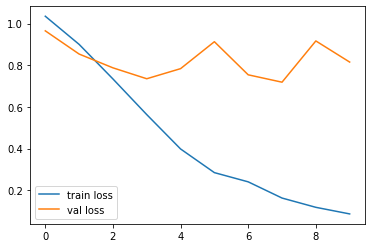

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='val loss')
plt.legend()

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       311
           1       0.89      0.58      0.71       171
           2       0.71      0.77      0.74       237

    accuracy                           0.78       719
   macro avg       0.80      0.75      0.76       719
weighted avg       0.79      0.78      0.77       719



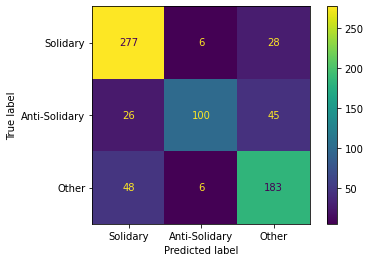

In [14]:
run_metrics(best_checkpoint_path, dev_data)

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       311
           1       0.86      0.69      0.76       171
           2       0.64      0.87      0.74       237

    accuracy                           0.77       719
   macro avg       0.80      0.77      0.77       719
weighted avg       0.80      0.77      0.78       719



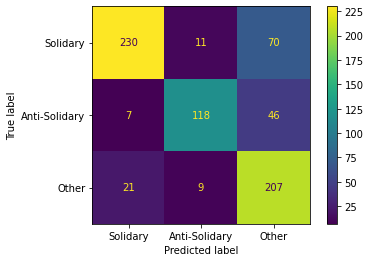

In [15]:
run_metrics(last_checkpoint_path, dev_data)